In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
import os
from pathlib import Path
from tqdm import tqdm
from timeit import default_timer as timer
from datetime import timedelta

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchmetrics.classification import BinaryCalibrationError

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

from scipy.stats import wasserstein_distance
from sklearn.metrics import roc_auc_score as roc_auc_score
from scipy.special import kl_div as kl_div
from sklearn.metrics import log_loss as log_loss

# import custom functions from src folder
module_path = str(Path.cwd() / "../../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *


In [16]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [17]:
def label_maker(values, num_classes):
    labels = np.zeros((len(values), num_classes))
    for i, value in enumerate(values):
        labels[i][value] = 1
    return torch.Tensor(labels).to(torch.int)

In [18]:
# Set up device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device {torch.cuda.get_device_name(1)}")

Using cuda device NVIDIA GeForce GTX 1080 Ti


In [19]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
n_data = [1000]#[250, 500, 1000, 2000, 3000, 5000, 10000]
bs_list = [128*2]#[128, 128, 128*2, 128*2, 1024, 1024, 1024*2]
#n_data = [10000]
max_err_val = [0]*len(n_data)
for i in range(len(n_data)):
    if n_data[i] < 1000:
        max_err_val[i] = 0.15
    else:
        max_err_val[i] = 0.1
patience = 30
load_values = True
save_values = False

#Data constants
shapes = [2, 6]#[2, 2]
scales = [5, 3]
k = len(scales) # Number of classes
d = 2 # Number of dimensions
p_c = [1/len(shapes)]*len(shapes) # Uniform distributon over classes

tag = f'k_{k}_d{d}_shapes{shapes}_scales{scales}_pc{p_c}'.replace(" ", "")

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
testfile = f"test_n_10000_{tag}"
gridfile = f"grid_x1_x2_10000_{tag}"
large_gridfile = f"grid_r_a1_2500_{tag}"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")
large_grid_data = pd.read_csv(f"../data/{large_gridfile}.csv")
grid_rmax = grid_data["x1"].max()
large_grid_rmax = large_grid_data["r"].max()

# Max accuracy on test set
max_acc = np.sum(train_data[[f"p_c{i}_given_r" for i in range(k)]].max(axis=1))/len(train_data)
print("Max acc train data: ", max_acc)
max_acc = np.sum(test_data[[f"p_c{i}_given_r" for i in range(k)]].max(axis=1))/len(test_data)
print("Max acc test data: ", max_acc)

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = label_maker(test_data["class"], 2)

X_grid = torch.Tensor(np.dstack((grid_data[x1_key], grid_data[x2_key]))).to(torch.float32)[0]
Y_grid = torch.zeros(X_grid.shape)

X_large_grid = torch.Tensor(np.dstack((large_grid_data[x1_key], large_grid_data[x2_key]))).to(torch.float32)[0]
Y_large_grid = torch.zeros(X_large_grid.shape)

Max acc train data:  0.7405497427147698
Max acc test data:  0.7385207198110306


In [20]:
# Create datasets for pytorch
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
grid_dataset = torch.utils.data.TensorDataset(X_grid, Y_grid)
large_grid_dataset = torch.utils.data.TensorDataset(X_large_grid, Y_large_grid)

## Ensembling

In [21]:

def train_ensemble(n_ensemble, n_train, batchsize):
    val_df = pd.read_csv(f"../data/{valfile}.csv")
    test_df = pd.read_csv(f"../data/{testfile}.csv")
    grid_df = pd.read_csv(f"../data/{gridfile}.csv")
    large_grid_df = pd.read_csv(f"../data/{large_gridfile}.csv")
    # Timer
    #start = timer()
    #print(f"Starting training of {n_ensemble} ensembles with {n_train} training points.")
    for i in range(n_ensemble):
        # Create datasets
        train_dataset = torch.utils.data.TensorDataset(X_train[0:n_train], Y_train[0:n_train])

        # Create new model
        model = SequentialNet(L=200, n_hidden=3, activation="relu", in_channels=2, out_channels=2).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Train model
        training_results = train_classifier(model, train_dataset, 
                                val_dataset, batchsize=batchsize, epochs = 200, 
                                device = device, optimizer = optimizer, early_stopping=patience)
        
        # Predict on validation set
        truth_val, logits_val = predict_classifier(model, val_dataset, 2, 100, device)
        preds_val = torch.argmax(logits_val, dim=-1).flatten()
        val_df[f"Logits0_{i}"] = logits_val[:,0]
        val_df[f"Logits1_{i}"] = logits_val[:,1]
        val_df[f"Prediction_{i}"] = preds_val
        val_df[f"Confidence_{i}"] = torch.softmax(logits_val, dim=-1)[:,1]

        # Predict on test set
        truth_test, logits_test = predict_classifier(model, test_dataset, 2, 100, device)
        preds_test = torch.argmax(logits_test, dim=-1).flatten()
        test_df[f"Logits0_{i}"] = logits_test[:,0]
        test_df[f"Logits1_{i}"] = logits_test[:,1]
        test_df[f"Prediction_{i}"] = preds_test
        test_df[f"Confidence_{i}"] = torch.softmax(logits_test, dim=-1)[:,1]

        # Predict for grid
        truth_grid, logits_grid = predict_classifier(model, grid_dataset, 2, 100, device)
        preds_grid = torch.argmax(logits_grid, dim=-1).flatten()
        grid_df[f"Logits0_{i}"] = logits_grid[:,0]
        grid_df[f"Logits1_{i}"] = logits_grid[:,1]
        grid_df[f"Prediction_{i}"] = preds_grid
        grid_df[f"Confidence_{i}"] = torch.softmax(logits_grid, dim=-1)[:,1] #Get softmax score for blue

        # Predict for grid
        truth_large_grid, logits_large_grid = predict_classifier(model, large_grid_dataset, 2, 100, device)
        preds_large_grid = torch.argmax(logits_large_grid, dim=-1).flatten()
        large_grid_df[f"Prediction_{i}"] = preds_large_grid
        large_grid_df[f"Logits0_{i}"] = logits_large_grid[:,0]
        large_grid_df[f"Logits1_{i}"] = logits_large_grid[:,1]
        large_grid_df[f"Confidence_{i}"] = torch.softmax(logits_large_grid, dim=-1)[:,1]

    #end = timer()
    #print("Training time: ", timedelta(seconds=end-start))
    return val_df, test_df, grid_df, large_grid_df

n_ensemble = 10
val_ensembles = [0]*len(n_data)
test_ensembles = [0]*len(n_data)
grid_ensembles = [0]*len(n_data)
large_grid_ensembles = [0]*len(n_data)

if load_values==False:
    for i in range(len(n_data)):
        logloss_min = 1
        for j in tqdm(range(1)):
            val_df, test_df, grid_df, large_grid_df = train_ensemble(n_ensemble, n_data[i], bs_list[i])
            val_df["Confidence_avg"] = val_df[[f"Confidence_{i}" for i in range(n_ensemble)]].mean(axis=1)
            val_df["Confidence_std"] = val_df[[f"Confidence_{i}" for i in range(n_ensemble)]].std(axis=1)
            val_df["Prediction_ensemble"] = 0
            mask = val_df["Confidence_avg"] > 0.5 # Equivalent to argmax for binary classification
            val_df.loc[mask, "Prediction_ensemble"] = 1

            ll = log_loss(val_df["class"], val_df["Confidence_avg"])
            preds = torch.Tensor(val_df["Confidence_avg"])
            target = torch.Tensor(val_df["class"])
            bce_l1 = BinaryCalibrationError(n_bins=15, norm='l1')
            ece = bce_l1(preds, target).item()
            #print(f"n_train = {n_data[i]}, logloss={ll}, ECE= {ece}")

            if ll < logloss_min:
                #print(f"New best values: n_train = {n_data[i]}, logloss={ll}, ECE= {ece}")
                logloss_min = ll

                val_ensembles[i] = val_df
                test_ensembles[i] = test_df
                grid_ensembles[i] = grid_df
                large_grid_ensembles[i] = large_grid_df

                test_ensembles[i]["Confidence_avg"] = test_ensembles[i][[f"Confidence_{i}" for i in range(n_ensemble)]].mean(axis=1)
                test_ensembles[i]["Confidence_std"] = test_ensembles[i][[f"Confidence_{i}" for i in range(n_ensemble)]].std(axis=1)
                test_ensembles[i]["Prediction_ensemble"] = 0
                mask = test_ensembles[i]["Confidence_avg"] > 0.5
                test_ensembles[i].loc[mask, "Prediction_ensemble"] = 1

                grid_ensembles[i]["Confidence_avg"] = grid_ensembles[i][[f"Confidence_{i}" for i in range(n_ensemble)]].mean(axis=1)
                grid_ensembles[i]["Confidence_std"] = grid_ensembles[i][[f"Confidence_{i}" for i in range(n_ensemble)]].std(axis=1)
                grid_ensembles[i]["Prediction_ensemble"] = 0
                mask = grid_ensembles[i]["Confidence_avg"] > 0.5
                grid_ensembles[i].loc[mask, "Prediction_ensemble"] = 1

                large_grid_ensembles[i]["Logits0_avg"] = large_grid_ensembles[i][[f"Logits0_{i}" for i in range(n_ensemble)]].mean(axis=1)
                large_grid_ensembles[i]["Logits1_avg"] = large_grid_ensembles[i][[f"Logits1_{i}" for i in range(n_ensemble)]].mean(axis=1)
                large_grid_ensembles[i]["Logits0_std"] = large_grid_ensembles[i][[f"Logits0_{i}" for i in range(n_ensemble)]].std(axis=1)
                large_grid_ensembles[i]["Logits1_std"] = large_grid_ensembles[i][[f"Logits1_{i}" for i in range(n_ensemble)]].std(axis=1)
                large_grid_ensembles[i]["Confidence_avg"] = large_grid_ensembles[i][[f"Confidence_{i}" for i in range(n_ensemble)]].mean(axis=1)
                large_grid_ensembles[i]["Confidence_std"] = large_grid_ensembles[i][[f"Confidence_{i}" for i in range(n_ensemble)]].std(axis=1)
                large_grid_ensembles[i]["Prediction_ensemble"] = 0
                mask = large_grid_ensembles[i]["Confidence_avg"] > 0.5
                large_grid_ensembles[i].loc[mask, "Prediction_ensemble"] = 1

        # Save best prediction
        if save_values:
            if (not os.path.isdir(f"predictions/{trainfile}") ):
                os.mkdir(f"predictions/{trainfile}")
            #val_ensembles.to_csv(f"predictions/{trainfile}/{valfile}_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv")
            test_ensembles[i].to_csv(f"predictions/{trainfile}/ensemble/{testfile}_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv")
            grid_ensembles[i].to_csv(f"predictions/{trainfile}/ensemble/grid_{tag}_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv")
            large_grid_ensembles[i].to_csv(f"predictions/{trainfile}/ensemble/large_grid_{tag}_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv")
            
else:
    #val_ensembles = [pd.read_csv(f"predictions/{trainfile}/{valfile}_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
    test_ensembles = [pd.read_csv(f"predictions/{trainfile}/ensemble/{testfile}_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
    grid_ensembles = [pd.read_csv(f"predictions/{trainfile}/ensemble/grid_{tag}_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
    large_grid_ensembles = [pd.read_csv(f"predictions/{trainfile}/ensemble/large_grid_{tag}_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]


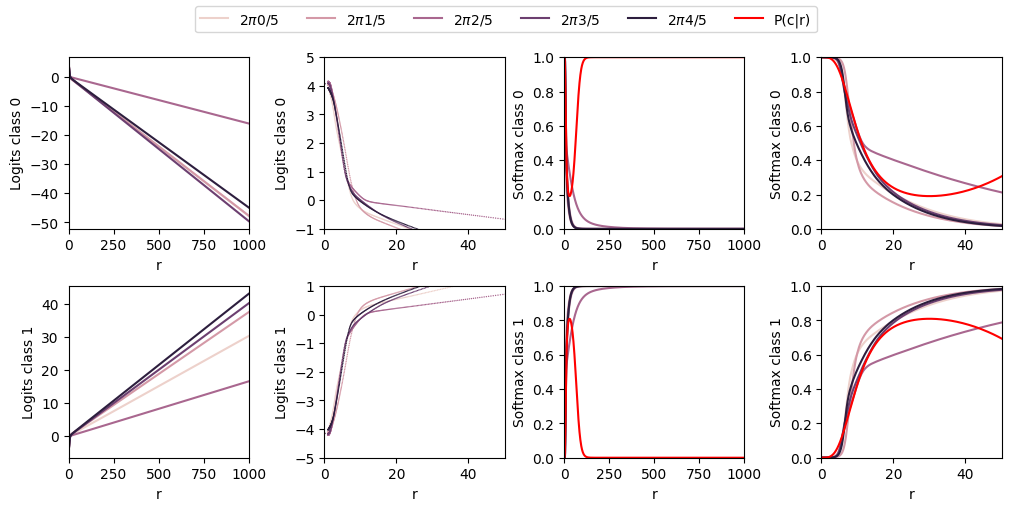

In [22]:
for i in range (len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (10, 5), layout="constrained")
    large_grid_ensembles[i]["Confidence0"] = 1 - large_grid_ensembles[i]["Confidence_avg"]
    #Plot logits
    sn.lineplot(large_grid_ensembles[i], x="r", y="Logits0_avg", hue="n_a1", ax=axs[0][0], legend=False)
    axs[0][0].set_ylabel("Logits class 0", size=10)
    axs[0][0].set_xlim(0, 1000)

    sn.scatterplot(large_grid_ensembles[i], x="r", y="Logits0_avg", hue="n_a1", ax=axs[0][1], s=1, alpha=1, linewidth=0, legend=False)
    axs[0][1].set_ylabel("Logits class 0", size=10)
    axs[0][1].set_xlim(0, grid_rmax)
    axs[0][1].set_ylim(-1, 5)

    sn.lineplot(large_grid_ensembles[i], x="r", y="Logits1_avg", hue="n_a1", ax=axs[1][0], legend=False)
    axs[1][0].set_ylabel("Logits class 1", size=10)
    axs[1][0].set_xlim(0, 1000)

    sn.scatterplot(large_grid_ensembles[i], x="r", y="Logits1_avg", hue="n_a1", ax=axs[1][1], s=1, alpha=1, linewidth=0, legend=False)
    axs[1][1].set_ylabel("Logits class 1", size=10)
    axs[1][1].set_xlim(0, grid_rmax)
    axs[1][1].set_ylim(-5, 1)

    #Plot estimated probabilities
    sn.lineplot(large_grid_ensembles[i], x="r", y="Confidence0", hue="n_a1", ax=axs[0][2], legend=False)
    sn.lineplot(large_grid_ensembles[i][large_grid_ensembles[i]["a1"]==0.0], x="r", y="p_c0_given_r", ax=axs[0][2], legend=False, color="red")
    axs[0][2].set_ylabel("Softmax class 0", size=10)
    axs[0][2].set_ylim(0, 1)
    axs[0][2].set_xlim(0, 1000)

    sn.lineplot(large_grid_ensembles[i], x="r", y="Confidence0", hue="n_a1", ax=axs[0][3], legend="full")
    sn.lineplot(large_grid_ensembles[i][large_grid_ensembles[i]["a1"]==0.0], x="r", y="p_c0_given_r", ax=axs[0][3], label="P(c|r)", color="red")
    axs[0][3].set_ylabel("Softmax class 0", size=10)
    axs[0][3].set_xlim(0, grid_rmax)
    axs[0][3].set_ylim(0, 1)

    sn.lineplot(large_grid_ensembles[i], x="r", y="Confidence_avg", hue="n_a1", ax=axs[1][2], legend=False)
    sn.lineplot(large_grid_ensembles[i][large_grid_ensembles[i]["a1"]==0.0], x="r", y="p_c1_given_r", ax=axs[1][2], legend=False, color="red")
    axs[1][2].set_ylabel("Softmax class 1", size=10)
    axs[1][2].set_ylim(0, 1)
    axs[1][2].set_xlim(0, 1000)

    sn.lineplot(large_grid_ensembles[i], x="r", y="Confidence_avg", hue="n_a1", ax=axs[1][3], legend=False)
    sn.lineplot(large_grid_ensembles[i][large_grid_ensembles[i]["a1"]==0.0], x="r", y="p_c1_given_r", ax=axs[1][3], legend=False, color="red")
    axs[1][3].set_ylabel("Softmax class 1", size=10)
    axs[1][3].set_xlim(0, grid_rmax)
    axs[1][3].set_ylim(0, 1)

    handles, labels = axs[0][3].get_legend_handles_labels()
    len_labels = len(labels) - 1
    for i in range(len_labels):
        labels[i] = rf"$2\pi${i}/{len_labels}"
    axs[0][3].get_legend().remove()
    fig.suptitle("    ", fontsize=26)
    fig.legend(handles, labels, loc='upper center', ncol=6, labelspacing=0.1, fontsize=10, markerscale=5)

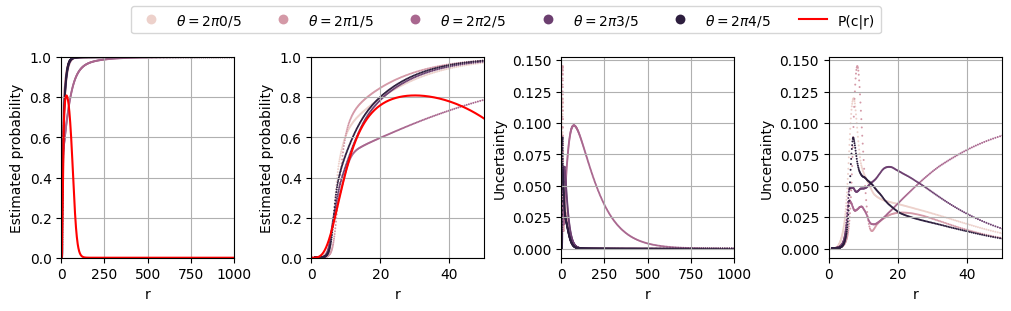

In [31]:
def plot_large_grid(df, prob_key, err_key):

    fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (10, 3), layout="constrained")

    #Plot estimated probabilities
    sn.scatterplot(df, x="r", y=prob_key, hue="n_a1", ax=axs[0], s=2, linewidth=0, alpha=1, legend="full")
    sn.lineplot(df[df["a1"]==0.0], x="r", y="p_c1_given_r", ax=axs[0], label="P(c|r)", color="red")
    axs[0].set_ylabel("Estimated probability", size=10)
    axs[0].set_xlim(0, large_grid_rmax)
    axs[0].set_ylim(0, 1)

    sn.scatterplot(df, x="r", y=prob_key, hue="n_a1", ax=axs[1], s=2, alpha=1, linewidth=0, legend=False)
    sn.lineplot(df[df["a1"]==0.0], x="r", y="p_c1_given_r", ax=axs[1], legend=False, color="red")
    axs[1].set_ylabel("Estimated probability", size=10)
    axs[1].set_xlim(0, grid_rmax)
    axs[1].set_ylim(0, 1)

    #Plot uncertainties
    sn.scatterplot(df, x="r", y=err_key, hue="n_a1", ax=axs[2], s=2, linewidth=0, alpha=1, legend=False)
    axs[2].set_ylabel("Uncertainty", size=10)
    #axs[2].set_ylim(0, 1)
    axs[2].set_xlim(0, large_grid_rmax)

    sn.scatterplot(df, x="r", y=err_key, hue="n_a1", ax=axs[3], s=2, linewidth=0, alpha=1, legend=False)
    axs[3].set_ylabel("Uncertainty", size=10)
    axs[3].set_xlim(0, grid_rmax)
    #axs[3].set_ylim(0, 1)

    for ax in axs:
        ax.grid(True)

    handles, labels = axs[0].get_legend_handles_labels()
    len_labels = len(labels) - 1
    for i in range(len_labels):
        labels[i] = rf"$\theta = 2\pi${i}/{len_labels}"
    axs[0].get_legend().remove()
    fig.suptitle("    ", fontsize=26)
    fig.legend(handles, labels, loc='upper center', ncol=len_labels+1, labelspacing=0.1, fontsize=10, markerscale=5)

for i in range(len(n_data)):
    plot_large_grid(large_grid_ensembles[i], "Confidence_avg", "Confidence_std")

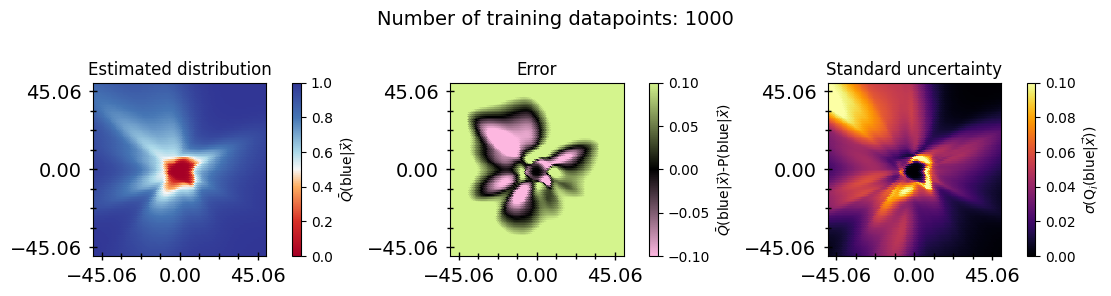

In [24]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")
    axs[0] = plot_results(grid_ensembles[i], "Confidence_avg", axs[0], "Estimated distribution", grid=True, rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), fraction=0.050, pad=0.04, label=r"$\bar{Q}$(blue|$\vec{x}$)", ax=axs[0])

    axs[1] = plot_diff(grid_ensembles[i], grid_ensembles[i], "Confidence_avg", "p_c1_given_r", axs[1], r"Error", max_val = max_err_val[i], rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=-max_err_val[i], vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()), 
                 fraction=0.050, pad=0.04, label=r"$\bar{Q}$(blue|$\vec{x}$)-P(blue|$\vec{x}$)", ax=axs[1])

    axs[2] = plot_std(grid_ensembles[i], "Confidence_std", axs[2], "Standard uncertainty", grid=True, max_val = max_err_val[i], rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"), fraction=0.050, pad=0.04, label=r"$\sigma$(Q$_i$(blue|$\vec{x}$))", ax=axs[2])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", fontsize=14)
    #fig.savefig(f"../fig/DNN_ensemble_ntrain_{n_data[i]}.pdf", format="pdf", bbox_inches='tight', dpi=350)

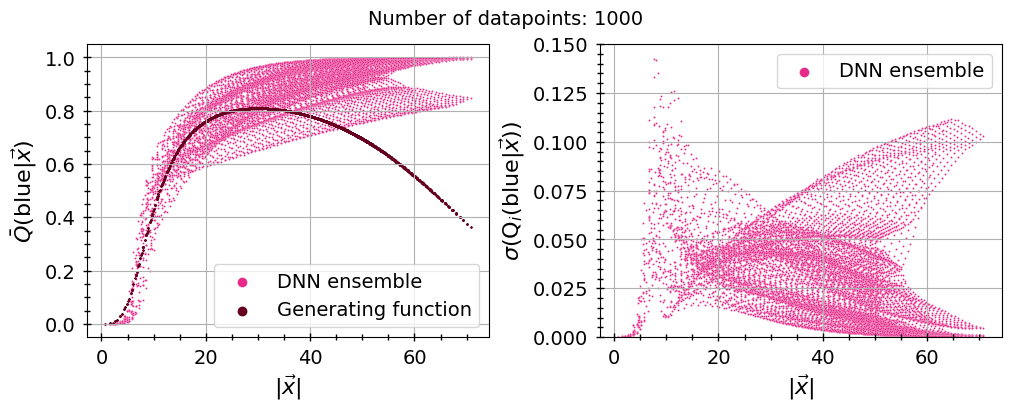

In [25]:

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
    sn.scatterplot(grid_ensembles[i], x="r", y="Confidence_avg", s=2, ax = axs[0], label="DNN ensemble", color="#e7298a")
    #sn.lineplot(truth_data, x="r_x", y="P_blue_given_x", linewidth=2, ax = axs[0], label="Generating function", color="#67001f")
    sn.scatterplot(grid_ensembles[0], x="r", y="p_c1_given_r", s=2, ax = axs[0], label="Generating function", color="#67001f", linewidth=0)
    axs[0].set_ylabel(r"$\bar{Q}$(blue|$\vec{x}$)", fontsize=16)

    sn.scatterplot(grid_ensembles[i], x="r", y="Confidence_std", s=2, ax = axs[1], label="DNN ensemble", color="#e7298a")
    axs[1].set_ylabel(r"$\sigma$(Q$_i$(blue|$\vec{x}$))", fontsize=16)
    axs[1].set_ylim(0, 0.15)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=14)
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
    fig.suptitle(f"Number of datapoints: {n_data[i]}", fontsize=14)

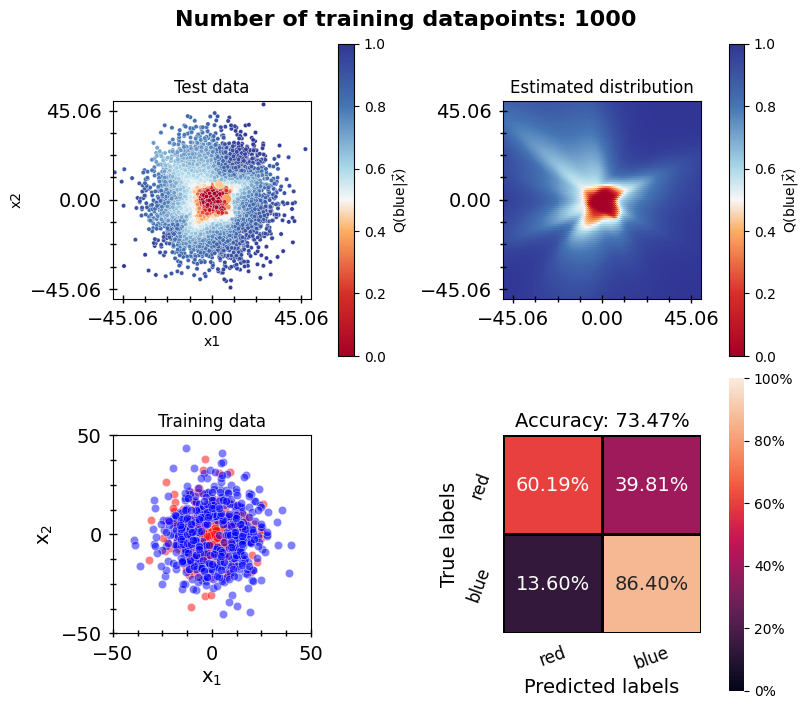

In [26]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")
    
    axs[0][0] = plot_results(test_ensembles[i], "Confidence_avg", axs[0][0], "Test data", "Confidence_std", rmax=grid_rmax)
    axs[0][1] = plot_results(grid_ensembles[i], "Confidence_avg", axs[0][1], "Estimated distribution", grid=True, rmax=grid_rmax)
    axs[1][1] = plot_conf_matrix(test_ensembles[i], "class", "Prediction_ensemble", ["red", "blue"], axs[1][1])
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data", rmax=grid_rmax)

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")


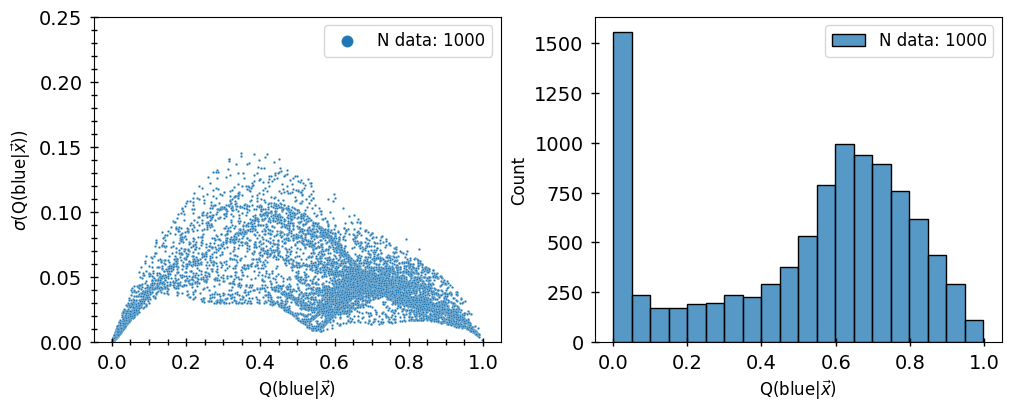

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(n_data)):
    sn.scatterplot(test_ensembles[i], x="Confidence_avg", y="Confidence_std", s=3, label=f"N data: {n_data[i]}", ax = axs[0])
    axs[0].legend(markerscale=5, fontsize=12)
    axs[0].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=12)
    axs[0].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    axs[0].set_ylim(0, 0.25)
    sn.histplot(test_ensembles[i], x="Confidence_avg", label=f"N data: {n_data[i]}", ax = axs[1], bins=20, edgecolor="black", linewidth=1)
    axs[1].legend(markerscale=5, fontsize=12)
    axs[1].set_ylabel("Count", fontsize=12)
    axs[1].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
    axs[0].minorticks_on()
    #fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")

In [28]:
scores = calculate_metrics(test_ensembles, grid_ensembles, n_data, grid_data, test_data, 
                           "Prediction_ensemble", "Confidence_avg", "Confidence_std")
scores.to_csv(f"predictions/{trainfile}/NNEscores.csv")
print(scores)

   N data       ACC    ROCAUC   WD test  WD grid    Avg UE    Std UE  \
0    1000  0.734673  0.794741  0.029851   0.1518  0.040784  0.026632   

   Mean KL-div test  Mean KL-div grid   LogLoss  Q-P dist       ECE       MCE  \
0          0.011661           0.02778  0.541307  0.064567  0.032138  0.191546   

      RMSCE  
0  0.044329  


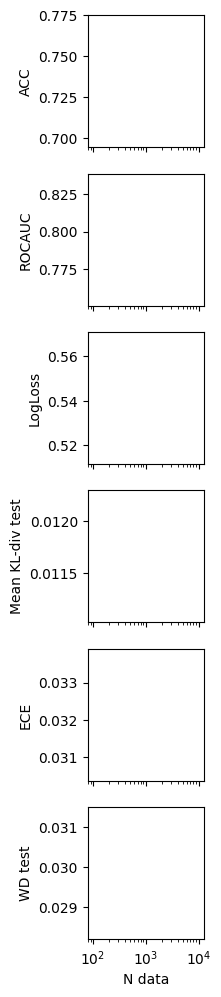

In [29]:
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(1.5, 12), sharex=True)
sn.lineplot(scores, x="N data", y="ACC", ax=axs[0])
sn.lineplot(scores, x="N data", y="ROCAUC", ax=axs[1])
sn.lineplot(scores, x="N data", y="LogLoss", ax=axs[2])
sn.lineplot(scores, x="N data", y="Mean KL-div test", ax=axs[3])
sn.lineplot(scores, x="N data", y="ECE", ax=axs[4])
sn.lineplot(scores, x="N data", y="WD test", ax=axs[5])

for ax in axs:
    ax.set_xscale("log")

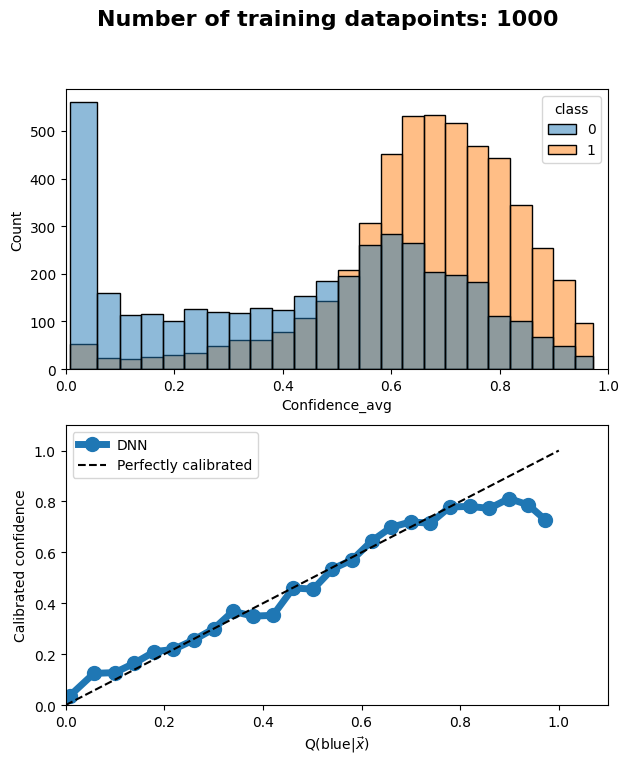

In [30]:
#Get confidence for red
for i in range(len(n_data)):
    prob_cal, prob_pred = calibration_curve(test_ensembles[i]["class"], test_ensembles[i]["Confidence_avg"], n_bins=25, strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 8))
    sn.histplot(test_ensembles[i], x="Confidence_avg", hue="class", ax=ax[0], stat="count", bins=pred_bins)
    ax[0].set_xlim(0,1)
    ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel(r"Q(blue|$\vec{x}$)")
    ax[1].set_ylabel("Calibrated confidence")
    ax[1].legend()
    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")